# Doublet Analysis

Project ArchR Doublet scores over UMAP with all cells (no doublet removal) to estimate doublet population.

In [9]:
library(GenomicRanges)
library(ggplot2)
library(scales)

In [70]:
# Metadata file from previous run
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../20200206_pmat_snapATAC/sessions/20200520_n68916/metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$cells = rownames(metaData) # for cicero
dim(metaData)
head(metaData, 5)

[1] 68916     6

,barcode,sample,umap1,umap2,cells,cluster
,<fct>,<fct>,<dbl>,<dbl>,<chr>,<int>
D0_AAACAACGACGATTAC,AAACAACGACGATTAC,D0,6.565758,-8.649868,D0_AAACAACGACGATTAC,5
D0_AAACAACGAGCGCACT,AAACAACGAGCGCACT,D0,5.604522,-7.835411,D0_AAACAACGAGCGCACT,5
D0_AAACACGCTACGCCAC,AAACACGCTACGCCAC,D0,5.130516,-7.593246,D0_AAACACGCTACGCCAC,5
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,4.926843,-8.365463,D0_AAACACGCTAGTACGG,6
D0_AAACACGCTCCTCAAA,AAACACGCTCCTCAAA,D0,6.056337,-5.647577,D0_AAACACGCTCCTCAAA,5


In [71]:
doublet_scores = data.frame(sample_barcode=c(), score=c())

# no doublet scores for D0 as it is a homogenous population
for (d in c("D2", "D4", "D6", "D8", "D10", "D12", "D14")) {
    cur_rds = readRDS(sprintf("./QualityControl/%s/%s-Doublet-Summary.rds", d, d))
    cur_doublet_scores = cur_rds$doubletResults$doubletScoreUMAP
    cur_doublet_scores = data.frame(sample_barcode=sub("#", "_", names(cur_doublet_scores)), 
                                    score=cur_rds$doubletResults$doubletScoreUMAP,
                                   enrich=cur_rds$doubletResults$doubletEnrichUMAP)
    
    doublet_scores = rbind(doublet_scores, cur_doublet_scores)
}

rownames(doublet_scores) = doublet_scores$sample_barcode
doublet_scores$sample_barcode = NULL

In [73]:
head(doublet_scores)
dim(doublet_scores)

,score,enrich
,<dbl>,<dbl>
D2_ATCGAGACTGTGGTGA,6.658828,2.133333
D2_CCCGACAGATGTTGTG,14.591094,2.600000
D2_CAGGCTTCTCTCATTT,2.150883,1.800000
D2_TCGCCGAGAGCTCTTC,5.674139,2.066667
D2_AAGTTTCCTCTATCTT,2.417885,1.822222
D2_TAGCTCGCTGCGGTTC,0.000000,1.244444


[1] 65883     2

In [74]:
dscores = doublet_scores[rownames(metaData), ]
dscores$score[is.na(dscores$score)] = 0
dscores$enrich[is.na(dscores$enrich)] = 0

In [75]:
quantile(dscores$score, 0.95)
quantile(dscores$enrich, 0.95)

95% 
23.51846

95% 
3.025

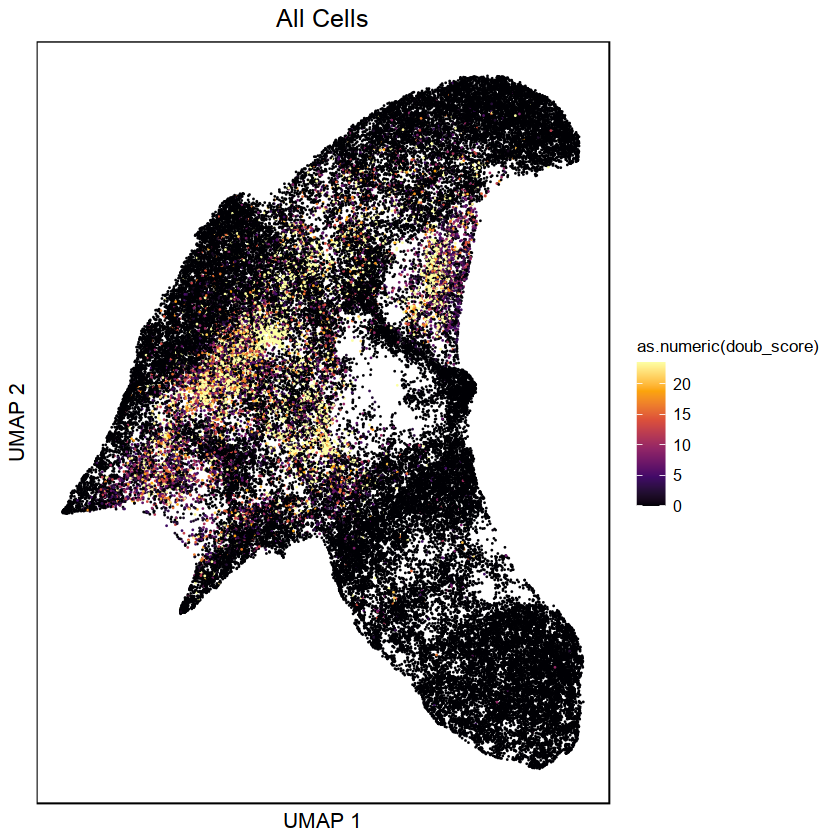

In [86]:
cur_score = dscores$score
df = data.frame(metaData, doub_score=cur_score)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(cur_score, 0.05), 
                               quantile(cur_score, 0.95)), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle("All Cells") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

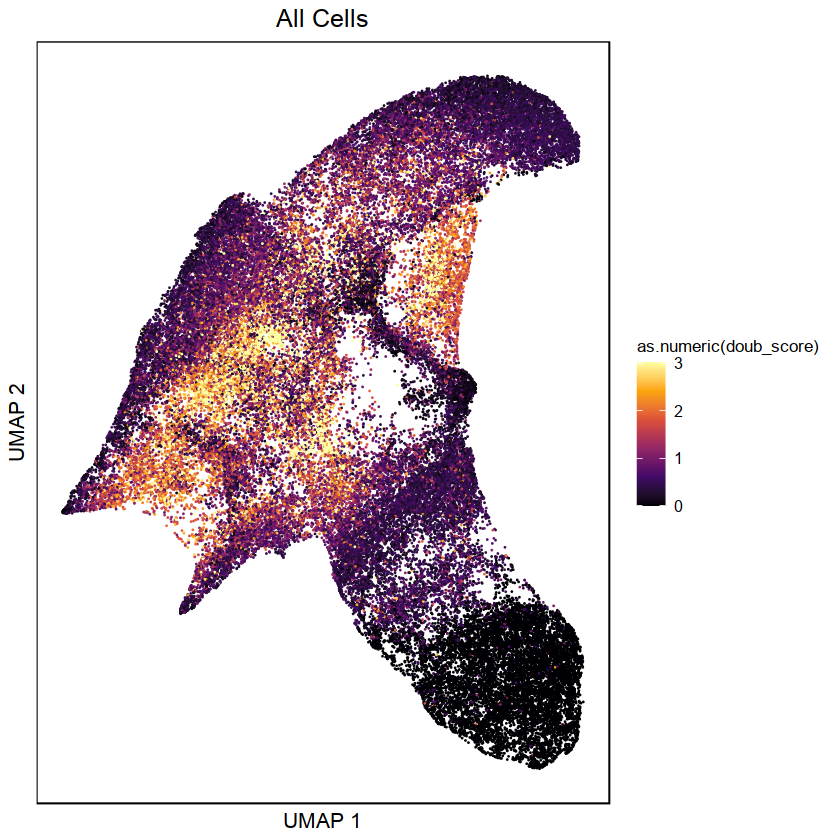

In [85]:
cur_score = dscores$enrich
df = data.frame(metaData, doub_score=cur_score)
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(quantile(cur_score, 0.05), 
                               quantile(cur_score, 0.95)), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle("All Cells") +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
      panel.border = element_rect(colour = "black", fill=NA, size=0.5))

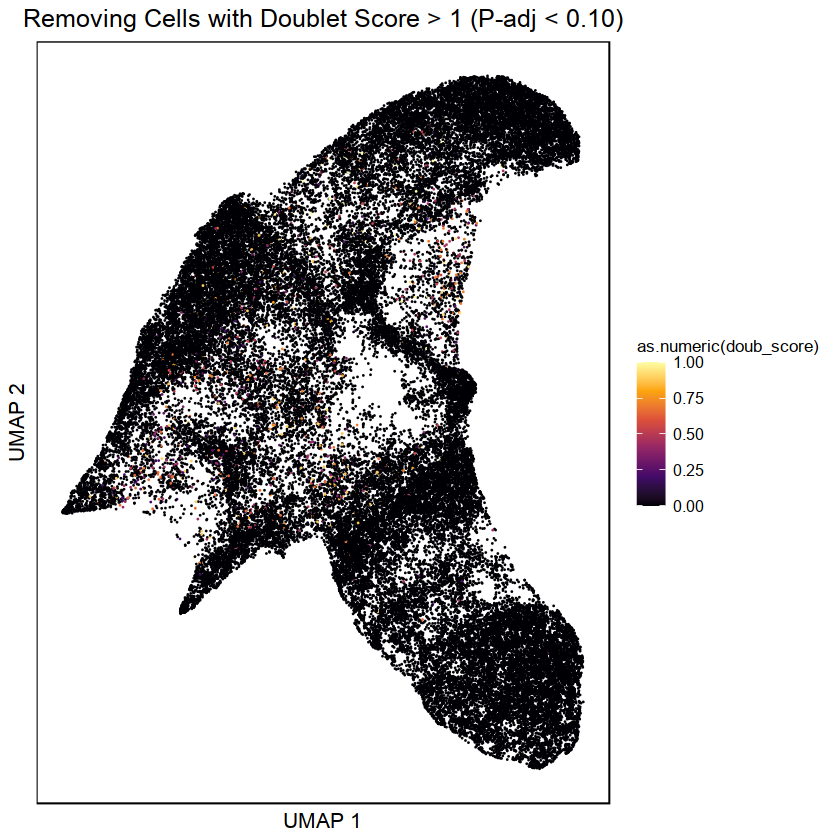

In [84]:
CUTOFF = 1
cur_score = dscores$score

df = data.frame(metaData[cur_score<=CUTOFF,], doub_score=cur_score[cur_score<=CUTOFF])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5, stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, CUTOFF), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle(sprintf("Removing Cells with Doublet Score > %d (P-adj < %.2f)", CUTOFF, 10^(-CUTOFF))) +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))

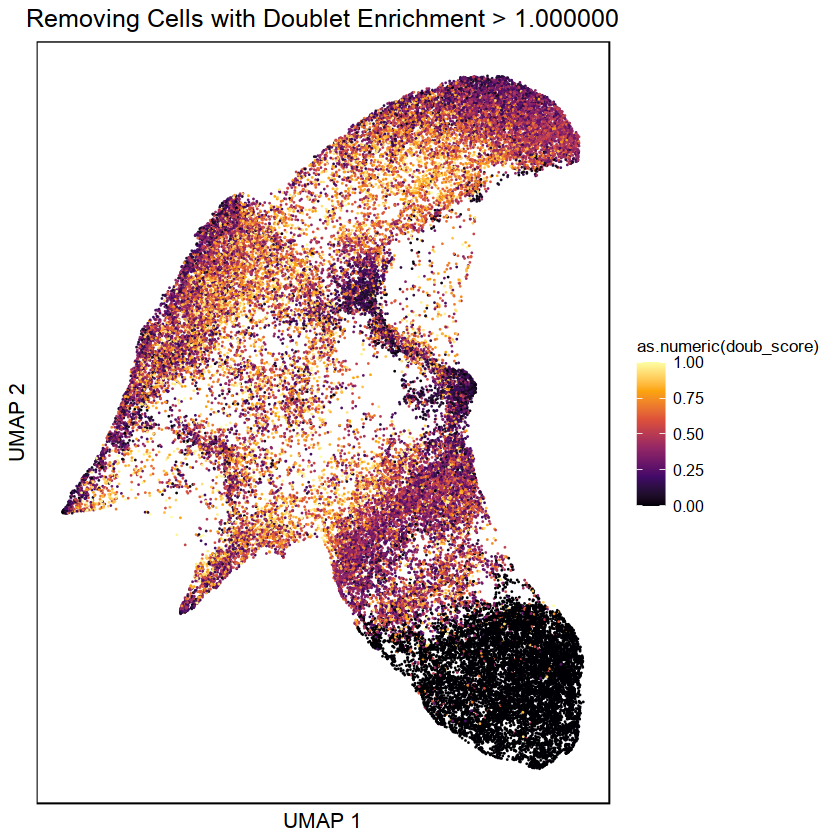

In [136]:
CUTOFF = 1.0
cur_score = dscores$enrich

df = data.frame(metaData[cur_score<=CUTOFF,], doub_score=cur_score[cur_score<=CUTOFF])
# shuffle so days don't overlap
df = df[sample(dim(df)[1]), ]

ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_point(size=0.5,stroke=0, alpha=1, aes(x=umap1 , y=umap2, col=as.numeric(doub_score))) +
xlab("UMAP 1") + ylab("UMAP 2") +
scale_color_viridis_c(limits=c(0, CUTOFF), 
                      oob=squish, option = "B") +
theme_classic() +
ggtitle(sprintf("Removing Cells with Doublet Enrichment > %f", CUTOFF)) +
theme(plot.title = element_text(hjust = 0.5),
      text = element_text(size=12),
      axis.line=element_blank(),
      axis.text.x=element_blank(),
      axis.text.y=element_blank(),
      axis.ticks=element_blank(),
      legend.title=element_text(size=10), 
      legend.text=element_text(size=9),
    panel.border = element_rect(colour = "black", fill=NA, size=0.5))

In [ ]:
sum(dscores$score<=1)
sum(dscores$enrich<=1.25)

In [87]:
# breakdown by cluster
doub_counts = table(metaData[dscores$enrich>1.25, "cluster"])
all_counts = table(metaData[metaData$cluster %in% names(doub_counts), "cluster"])

sort(doub_counts/all_counts)


           5            6           10            4            3           16 
0.0009511128 0.0013433122 0.0306372549 0.0922028766 0.1234567901 0.1488907850 
           2            1            9           11            7           12 
0.1838058965 0.2167841649 0.2423892989 0.2890952666 0.3208984375 0.4166407948 
          14           15           17            8           13 
0.4775343483 0.5396408235 0.6126663607 0.6509695291 0.8672776646 

## Write Barcodes

The above analyses were done on barcodes selected in a previous run. However, will write down all barcodes that pass multiple criteria.

In [109]:
# pull nFrags and TSS enrichment for all doublets
qc_scores = data.frame(sample_barcode=c(), nFrags=c(), tss=c())

for (d in c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "H1")) {
    cur_rds = readRDS(sprintf("./QualityControl/%s/%s-Pre-Filter-Metadata.rds", d, d))
    cur_qc = data.frame(sample_barcode=sub("#", "_", cur_rds$cellNames),
                        nFrags = cur_rds$nFrags,
                        tss = cur_rds$TSSEnrichment,
                       sample=d)
    qc_scores = rbind(qc_scores, cur_qc)
}

rownames(qc_scores) = qc_scores$sample_barcode
qc_scores$sample_barcode = NULL

In [111]:
# add doublet enrichment
qc_scores$doublet_enrich = doublet_scores[rownames(qc_scores), "enrich"]
qc_scores$doublet_enrich[is.na(qc_scores$doublet_enrich)] = 0

In [112]:
dim(qc_scores)
head(qc_scores)

[1] 99617     4

,nFrags,tss,sample,doublet_enrich
,<dbl>,<dbl>,<fct>,<dbl>
D0_CATGCAAACTGCGCCA,72241,4.310,D0,0
D0_CCCATGTACAGCTTTG,70088,9.713,D0,0
D0_AAGGTAATGACGCGAA,68843,10.239,D0,0
D0_CTAGCTCACCCGTTAA,68035,10.787,D0,0
D0_GGTTCCTTGCGAGTTT,66577,9.515,D0,0
D0_CAGTGGAGAGCTCTTC,66485,9.687,D0,0


In [115]:
TSS = 6
NFRAG = 1000
ENRICH = 1.25

In [116]:
criteria = (qc_scores$nFrags>NFRAG)&(qc_scores$tss>TSS)&(qc_scores$doublet_enrich<=ENRICH)
sum(criteria)

[1] 62402

In [117]:
table(qc_scores[criteria, "sample"])


   D0    D2    D4    D6    D8   D10   D12   D14    H1 
10824  6265  5509  7448  7202  1425  3039 13608  7082 

In [124]:
DIR = sprintf("../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_%d_TSS_%d_doublet_enrichment_%.2f", NFRAG, TSS, ENRICH)
DIR

[1] "../20200122_snapATAC/barcodeLists/20201019_ArchR_nFrags_1000_TSS_6_doublet_enrichment_1.25"

In [125]:
subset = qc_scores[criteria, ]
dim(subset)

[1] 62402     4

In [129]:
write.table(subset, sprintf("%s/scores.tsv", DIR),
           sep='\t', quote=F, row.names=T, col.names=T)

In [135]:
for (x in unique(qc_scores$sample)) {
    cur_barcodes = lapply(strsplit(rownames(subset[(subset$sample==x), ]), "_"), "[[", 2)
    write.table(unlist(cur_barcodes),
                sprintf("%s/%s.barcodes.txt", DIR, x), 
                row.names=F,
                col.names=F,
                quote=F)
}

In [59]:
# OLD

# write barcodes with zero doublet score (most stringent) for replotting UMAP
# for (x in unique(metaData$sample)) {
#     cur_barcodes = metaData[(metaData$sample==x)&(dscores==0), "barcode"]
#     write.table(unlist(cur_barcodes),
#                 sprintf("../20200206_pmat_snapATAC/barcodeLists/20200531_ArchR_doublet_score_0/%s.barcodes.txt", x), 
#                 row.names=F,
#                 col.names=F,
#                 quote=F)
# }